In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import required Libraries**

In [1]:
! pip install -q tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 8.3 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.keras.compat import keras

# **Load data**

In [9]:
batch_size = 64
img_height = 224
img_width = 224

data_dir = "/content/drive/MyDrive/New Folder/TinyML/Datasets/Tomatoes Diseases/"

In [10]:
train_ds = keras.utils.image_dataset_from_directory(
    data_dir + "Train",
    validation_split=0.2,
    subset="training",
    seed=440,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 12860 files belonging to 10 classes.
Using 10288 files for training.


In [14]:
val_ds = keras.utils.image_dataset_from_directory(
    data_dir + "Train",
    validation_split=0.2,
    subset="validation",
    seed=440,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 12860 files belonging to 10 classes.
Using 2572 files for validation.


In [11]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "Test",
    seed=440,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 3198 files belonging to 10 classes.


In [24]:
class_names = train_ds.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mite_Two_spotted_sm',
 'Target_Spot',
 'Yellow_Leaf__Curl_Virus',
 'healthy',
 'mosaic_virus']

# **Visualize the data**

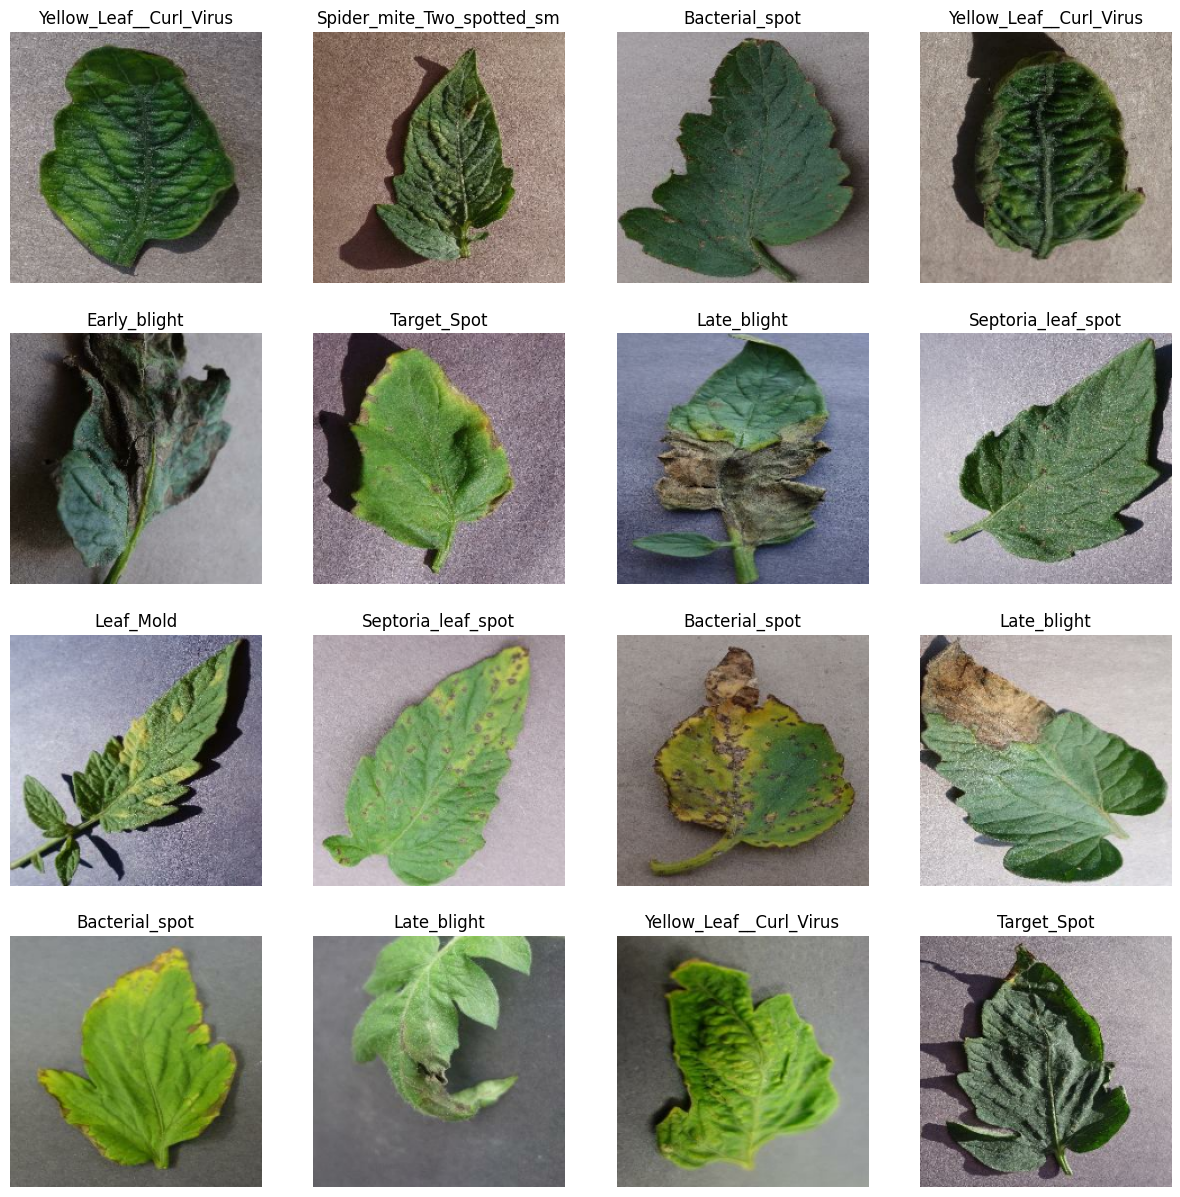

In [ ]:
plt.figure(figsize=(15, 15))
for img, lab in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[lab[i]])
    plt.axis("off")

# **Preprocess the data**

In [15]:
# set 8000 images for training and 1024 images for validation
train_nds = train_ds.take(125)
val_nds = val_ds.take(16)
test_nds = test_ds.take(16)

In [16]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

train_nds = train_nds.cache().prefetch(buffer_size=AUTOTUNE)
val_nds = val_nds.cache().prefetch(buffer_size=AUTOTUNE)
test_nds = test_nds.cache().prefetch(buffer_size=AUTOTUNE)

# **Load Model**

In [23]:
# Create the base model from the pre-trained model MobileNet V2

base_model = keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

In [24]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [25]:
num_images = 8000
end_step = np.ceil(num_images / batch_size).astype(np.int32) * 30


callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]

pruning_params = {
    "pruning_schedule": tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.10,
        final_sparsity=0.70,
        begin_step=0,
        end_step=end_step,)
}



In [26]:
MobileNet = tfmot.sparsity.keras.prune_low_magnitude(base_model, **pruning_params)

In [27]:
MobileNet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 prune_low_magnitude_Conv1   (None, 112, 112, 32)         1730      ['input_3[0][0]']             
 (PruneLowMagnitude)                                                                              
                                                                                                  
 prune_low_magnitude_bn_Con  (None, 112, 112, 32)         129       ['prune_low_magnitude_Conv1[0]
 v1 (PruneLowMagnitude)                                             [0]']                         
                                                                               

In [28]:
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

In [29]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = preprocess_input(inputs)
x = MobileNet(inputs, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = tfmot.sparsity.keras.prune_low_magnitude(keras.layers.Dense(10), **pruning_params)(x)
pruned_MobileNet = keras.Model(inputs, outputs)

In [30]:
pruned_MobileNet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        4383708   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 prune_low_magnitude_dense_  (None, 10)                25612     
 1 (PruneLowMagnitude)                                           
                                                           

# **Pruning**

# **Compile and train the model**

In [31]:
pruned_MobileNet.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=keras.optimizers.Adam(learning_rate=1e-5),
  metrics=['accuracy']
)

pruned_MobileNet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        4383708   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 prune_low_magnitude_dense_  (None, 10)                25612     
 1 (PruneLowMagnitude)                                           
                                                           

In [32]:
history = pruned_MobileNet.fit(
    train_nds,
    validation_data=val_nds,
    epochs=30,
    callbacks=callbacks,
)

Epoch 1/30
125/125 [==============================] - 111s 450ms/step - loss: 1.8914 - accuracy: 0.3767 - val_loss: 1.3151 - val_accuracy: 0.6045
Epoch 2/30
125/125 [==============================] - 37s 294ms/step - loss: 1.0093 - accuracy: 0.7036 - val_loss: 0.8799 - val_accuracy: 0.7432
Epoch 3/30
125/125 [==============================] - 36s 291ms/step - loss: 0.6808 - accuracy: 0.8079 - val_loss: 0.6232 - val_accuracy: 0.8174
Epoch 4/30
125/125 [==============================] - 37s 298ms/step - loss: 0.4925 - accuracy: 0.8651 - val_loss: 0.5028 - val_accuracy: 0.8672
Epoch 5/30
125/125 [==============================] - 37s 292ms/step - loss: 0.3859 - accuracy: 0.8957 - val_loss: 0.4156 - val_accuracy: 0.8838
Epoch 6/30
125/125 [==============================] - 36s 291ms/step - loss: 0.3215 - accuracy: 0.9119 - val_loss: 0.3601 - val_accuracy: 0.8975
Epoch 7/30
125/125 [==============================] - 37s 295ms/step - loss: 0.2820 - accuracy: 0.9252 - val_loss: 0.3272 - val_a

In [33]:
def plot_curves(his):

    loss = his.history['loss']
    val_loss = his.history['val_loss']

    accuracy = his.history['accuracy']
    val_accuracy = his.history['val_accuracy']

    epochs = range(len(his.history['loss']))

    # ploting the loss
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure()

    # ploting the accuracy
    plt.plot(epochs, accuracy, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.figure()

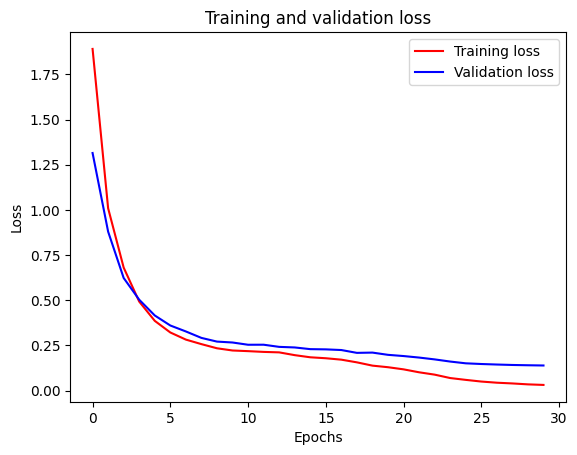

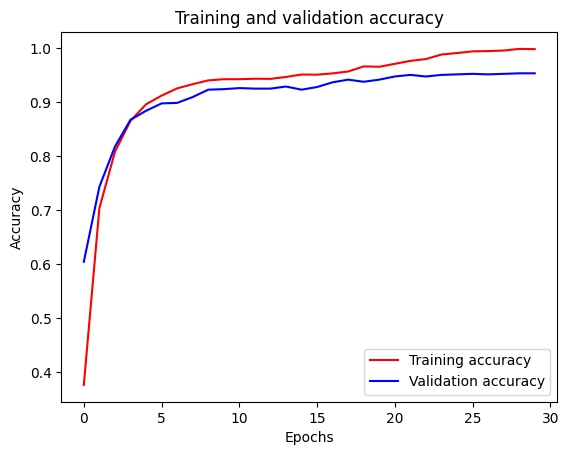

<Figure size 640x480 with 0 Axes>

In [34]:
plot_curves(history)

In [35]:
def print_model_weights_sparsity(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

In [36]:
pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_MobileNet)
print_model_weights_sparsity(pruned_model)

Conv1/kernel:0: 70.02% sparsity  (605/864)
expanded_conv_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/288)
expanded_conv_project/kernel:0: 69.92% sparsity  (358/512)
block_1_expand/kernel:0: 69.99% sparsity  (1075/1536)
block_1_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/864)
block_1_project/kernel:0: 70.01% sparsity  (1613/2304)
block_2_expand/kernel:0: 69.99% sparsity  (2419/3456)
block_2_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1296)
block_2_project/kernel:0: 69.99% sparsity  (2419/3456)
block_3_expand/kernel:0: 69.99% sparsity  (2419/3456)
block_3_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1296)
block_3_project/kernel:0: 70.01% sparsity  (3226/4608)
block_4_expand/kernel:0: 70.00% sparsity  (4301/6144)
block_4_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1728)
block_4_project/kernel:0: 70.00% sparsity  (4301/6144)
block_5_expand/kernel:0: 70.00% sparsity  (4301/6144)
block_5_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1728)
block_5_project/kernel:0: 

In [17]:
pruned_model = keras.models.load_model('drive/MyDrive/New Folder/TinyML/SaveModels/pruned_MobileNet.h5')

In [18]:
pruned_model.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=keras.optimizers.Adam(learning_rate=1e-5),
  metrics=['accuracy']
)

pruned_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2270794 (8.66 MB)
Trainable params: 2236682 (

In [42]:
rescale = keras.layers.Rescaling(1./255)
test_nds = test_nds.map(lambda x, y: (rescale(x), y))

In [19]:
loss, acc = pruned_model.evaluate(test_nds)
print("Accuracy", acc)
print("Loss", loss)

16/16 [==============================] - 253s 10s/step - loss: 0.1552 - accuracy: 0.9463
Accuracy 0.9462890625
Loss 0.15517176687717438


In [38]:
model = "drive/MyDrive/New Folder/TinyML/SaveModels/pruned_MobileNet.h5"
keras.models.save_model(pruned_model, model, include_optimizer=False)


<ipython-input-38-f4ac579e397b>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(pruned_model, model, include_optimizer=False)


In [21]:
# Get predictions
y_pred = pruned_model.predict(test_nds)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_nds], axis=0)

# Compute confusion matrix
cm = tf.math.confusion_matrix(y_true, y_pred)

16/16 [==============================] - 79s 5s/step


In [26]:
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[132,   0,   1,   0,   1,   0,   1,   1,   0,   0],
       [  0,  48,   6,   0,   2,   0,   2,   0,   0,   1],
       [  0,   5, 115,   1,   1,   1,   1,   2,   0,   0],
       [  0,   0,   1,  50,   1,   1,   0,   0,   0,   0],
       [  4,   2,   0,   2, 112,   1,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0, 113,   2,   1,   0,   0],
       [  2,   0,   0,   0,   2,   3,  82,   0,   0,   1],
       [  0,   0,   0,   1,   0,   2,   0, 186,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 114,   0],
       [  0,   0,   0,   0,   1,   0,   0,   1,   0,  17]], dtype=int32)>

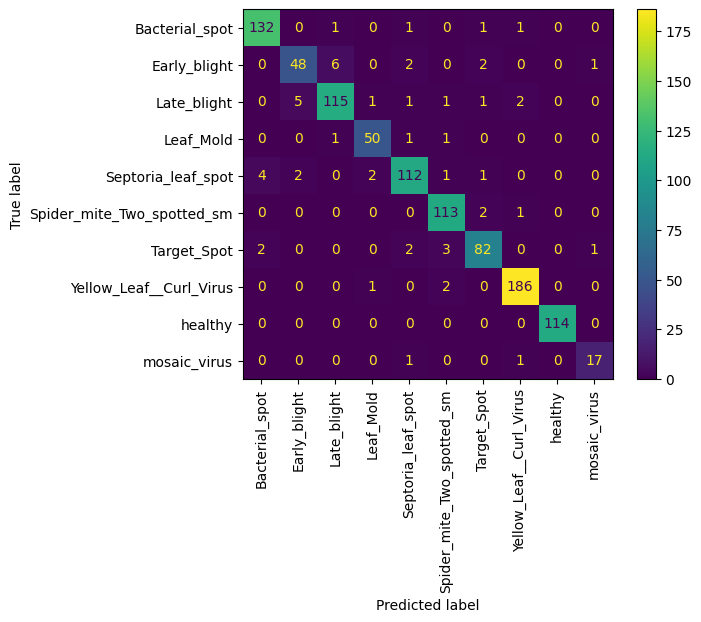

In [25]:
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=class_names, xticks_rotation='vertical'
)

In [23]:
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Accuracy", acc)
print("Loss", loss)

Precision: 0.9347259064471926
Recall: 0.9322387851704612
F1 Score: 0.9332974791607525
Accuracy 0.9462890625
Loss 0.15517176687717438
